# Python AWIPS Data Access Framework

The `python-awips` package provides a Data Acccess Framework (DAF) for requesting data from a remote AWIPS II EDEX server.  

The AWIPS II Python Stack installed via RPM contains the DAF, matplotlib, numpy, scipy, basemap, pint, shapely, and other packages. 

## Listing a Grid Inventory

In [51]:
from awips.dataaccess import DataAccessLayer

# Set host
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

# Init data request
request = DataAccessLayer.newDataRequest()

# Set datatype
request.setDatatype("grid")

# getAvailableLocationNames method will return a list of all available models
available_grids = DataAccessLayer.getAvailableLocationNames(request)
for grid in available_grids:
    print grid
    

GFSLAMP5
GFSGuide
ECMF6
ECMF3
ECMF4
HPCqpfNDFD
ECMF-Global
RAP13
ECMF5
RTMA5
AVN211
NamDNG
ECMF9
QPE-MSR
estofsUS
ECMF12
ECMF10
ECMF8
MRMS_1000
ETA
LAMP2p5
HRRR
URMA25
GFS40
GFS
RAP40
RTMA
AVN225
NAM12
ECMF1
ECMF2
ECMF11
DGEX
NamDNG5
estofsPR
NCWF
ECMF7
NOHRSC-SNOW
HPCGuide
NAM40


**LocationNames** is different for different plugins
- radar is icao
- satellite is sector


## Requesting a Grid

In [52]:
# Grid request
request.setLocationNames('RAP40')
request.setParameters("RH")
request.setLevels("850MB")

# Get available times
t = DataAccessLayer.getAvailableTimes(request)

# Select last available time [-1]
response = DataAccessLayer.getGridData(request, [t[-1]])
data = response[0]

# Print info
print data.getLocationName()
print t[-1]
print 'Unit is', data.getUnit()
print 'Parameter is', data.getParameter()

# Print data array
print data.getRawData()

# Print lat/lon array
lon,lat = data.getLatLonCoords()
print "lat array =", lat
print "lon array =", lon

RAP40
2016-02-23 15:00:00 (12)
Unit is %
Parameter is RH
[[ 100.02842712  100.02842712  100.02842712 ...,   60.02842712
    60.02842712   63.02842712]
 [  63.02842712   60.02842712   52.02842712 ...,   90.02842712
    91.02842712   91.02842712]
 [  90.02842712   91.02842712   90.02842712 ...,   41.02842712
    40.02842712   38.02842712]
 ..., 
 [  54.02842712   62.02842712   62.02842712 ...,   51.02842712
    57.02842712   50.02842712]
 [  40.02842712   37.02842712   31.02842712 ...,    1.02842677
     3.02842665    5.02842665]
 [   7.02842665    7.02842665    9.02842712 ...,   69.02842712
    65.02842712   65.02842712]]
lat array = [[ 54.24940109  54.35071945  54.45080566 ...,  57.9545517   57.91926193
   57.88272858]
 [ 57.84495163  57.80593109  57.76566696 ...,  58.07667542  58.08861542
   58.09931183]
 [ 58.10876846  58.11697769  58.12394714 ...,  56.40270996  56.46187973
   56.51980972]
 ..., 
 [ 19.93209648  19.89832115  19.86351395 ...,  20.054636    20.06362152
   20.07156372]


## Plotting a Grid using Basemap

Using **matplotlib**, **numpy**, and **basemap**:

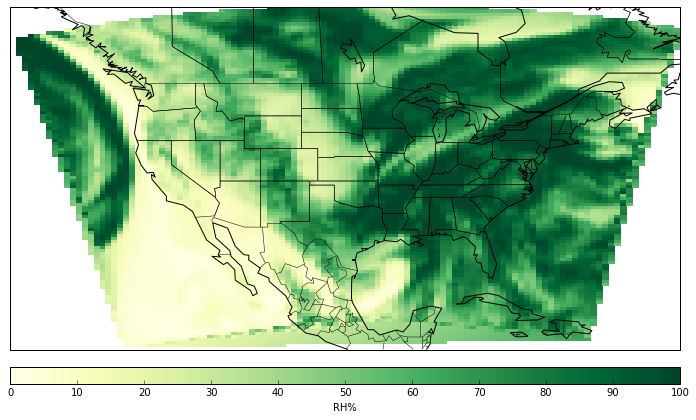

In [53]:
%matplotlib inline
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
from numpy import linspace, transpose
from numpy import meshgrid
from pint import UnitRegistry

plt.figure(figsize=(12, 12), dpi=100)
lons,lats = data.getLatLonCoords()

map = Basemap(projection='cyl',
      resolution = 'c',
      llcrnrlon = lons.min(), llcrnrlat = lats.min(),
      urcrnrlon =lons.max(), urcrnrlat = lats.max()
)
map.drawcoastlines()
map.drawstates()
map.drawcountries()

# 
# We have to reproject our grid, see https://stackoverflow.com/questions/31822553/m
#
x = linspace(0, map.urcrnrx, data.getRawData().shape[1])
y = linspace(0, map.urcrnry, data.getRawData().shape[0])
xx, yy = meshgrid(x, y)
ngrid = len(x)
rlons = np.repeat(np.linspace(np.min(lons), np.max(lons), ngrid),
          ngrid).reshape(ngrid, ngrid)
rlats = np.repeat(np.linspace(np.min(lats), np.max(lats), ngrid),
          ngrid).reshape(ngrid, ngrid).T
tli = mtri.LinearTriInterpolator(mtri.Triangulation(lons.flatten(),
          lats.flatten()), data.getRawData().flatten())
rdata = tli(rlons, rlats)
cs = map.pcolormesh(rlons, rlats, rdata, latlon=True, vmin=0, vmax=100, cmap='YlGn')

# add colorbar.
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label(data.getParameter() + data.getUnit() )

# Show plot
plt.show()


## Plotting a Grid using Cartopy


In [54]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np

from cartopy import config
import cartopy.crs as ccrs


# get the path of the file. It can be found in the repo data directory.
fname = os.path.join(config["repo_data_dir"],
                     'netcdf', 'HadISST1_SST_update.nc'
                     )

dataset = netcdf_dataset(fname)
sst = dataset.variables['sst'][0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

ImportError: No module named netCDF4